<a href="https://colab.research.google.com/github/RajeshworM/Yield_Modelling_Automation/blob/main/VIF_FirstStep_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload panel data.


Saving vif.csv to vif (7).csv
Loading vif (7).csv ...
First rows:
   year  district_id  yield  econ_inc_rev1  econ_inc_rev2  gw_reciprocal  \
0  2005            6   3320       52257.72       49135.00           0.08   
1  2006            6   3450       56556.71       52988.25           0.16   
2  2007            6   3690       60640.28       56550.58           0.08   
3  2008            6   3300       72365.51       67821.63           0.12   
4  2009            6   3720       72794.12       69069.77           0.08   

   reservoir_intensity  nia_intensity  planting_rain  vegetative_rain  \
0                 0.03           1.57         445.64           346.15   
1                 0.05           1.48         329.77           317.97   
2                 0.04           1.52         525.48           490.74   
3                 0.02           1.39         610.00           500.31   
4                 0.02           1.38         312.69           216.38   

   reproductive_rain  ripening_rain  p

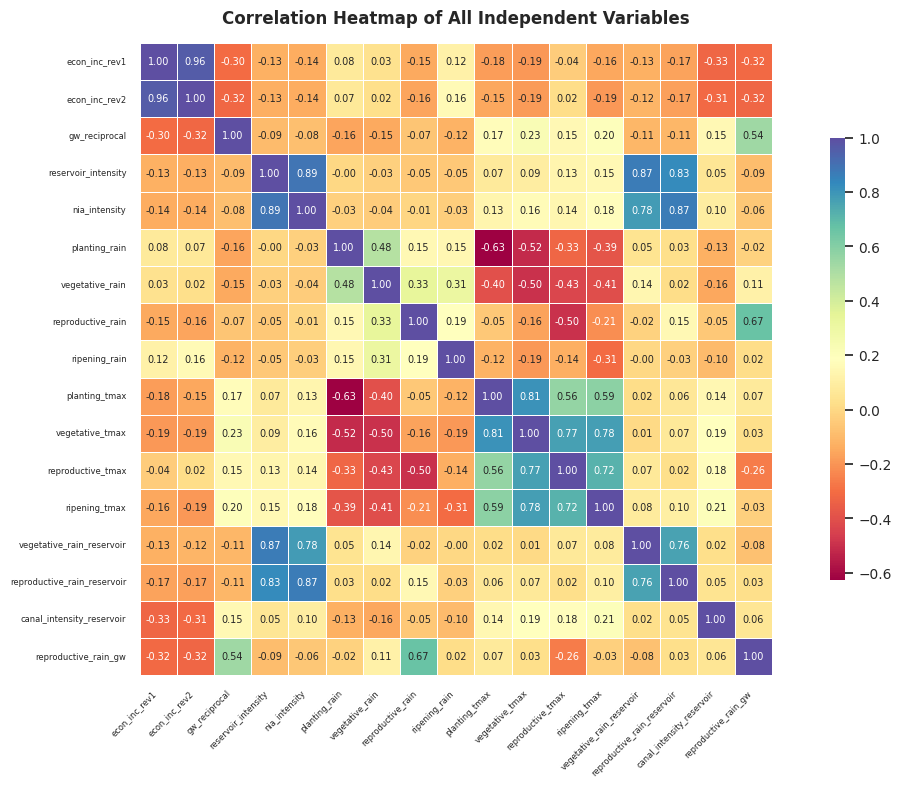


Initial candidate predictors (17): ['econ_inc_rev1', 'econ_inc_rev2', 'gw_reciprocal', 'reservoir_intensity', 'nia_intensity', 'planting_rain', 'vegetative_rain', 'reproductive_rain', 'ripening_rain', 'planting_tmax', 'vegetative_tmax', 'reproductive_tmax', 'ripening_tmax', 'vegetative_rain_reservoir', 'reproductive_rain_reservoir', 'canal_intensity_reservoir', 'reproductive_rain_gw']

Missing counts (target + predictors):
yield                          0
econ_inc_rev1                  0
econ_inc_rev2                  0
gw_reciprocal                  0
reservoir_intensity            0
nia_intensity                  0
planting_rain                  0
vegetative_rain                0
reproductive_rain              0
ripening_rain                  0
planting_tmax                  0
vegetative_tmax                0
reproductive_tmax              0
ripening_tmax                  0
vegetative_rain_reservoir      0
reproductive_rain_reservoir    0
canal_intensity_reservoir      0
reproductiv

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# Full Colab-ready pipeline: Verbose VIF -> p-value selection -> FE/RE -> Hausman
# Run in Google Colab. It will prompt file upload.
# VIF cutoff = 5, p-value cutoff = 0.10

# Install required packages
!pip install linearmodels --quiet

# Imports
import io
import numpy as np
import pandas as pd
import statsmodels.api as sm
from google.colab import files
from linearmodels.panel import PanelOLS, RandomEffects
from scipy import stats

# -----------------------
# 1) Upload CSV
# -----------------------
print("Upload panel data.")
uploaded = files.upload()
if len(uploaded) == 0:
    raise SystemExit("No file uploaded.")
fname = list(uploaded.keys())[0]
print(f"Loading {fname} ...")
df = pd.read_csv(io.BytesIO(uploaded[fname]))
print("First rows:")
print(df.head())


# -----------------------
# 2b) Correlation heatmap of all independent variables
# -----------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Take all predictors except dependent + IDs
all_iv = df[predictors].copy()

# Coerce to numeric (errors='coerce' turns non-numeric to NaN)
all_iv = all_iv.apply(pd.to_numeric, errors='coerce')

# Drop rows with missing for correlation calc
corr = all_iv.corr()

plt.figure(figsize=(12, 8))
sns.set(style="white", font_scale=0.9)

# Choose a beautiful diverging colormap
cmap = sns.color_palette("Spectral", as_cmap=True)

ax = sns.heatmap(corr,
                 annot=True,
                 fmt=".2f",
                 cmap=cmap,
                 square=True,
                 cbar_kws={"shrink": 0.7, "aspect": 30},
                 linewidths=0.4,
                 annot_kws={"size": 7})

# Style tweaks
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.title("Correlation Heatmap of All Independent Variables",
          fontsize=12, pad=14, weight="bold")
plt.tight_layout()
plt.show()


# -----------------------
# Helper functions
# -----------------------
def ensure_numeric_predictors(df, predictors):
    """Coerce predictors to numeric where possible; drop non-coercible."""
    preds = predictors.copy()
    for c in predictors.copy():
        if not pd.api.types.is_numeric_dtype(df[c]):
            coerced = pd.to_numeric(df[c], errors='coerce')
            if coerced.notna().sum() > 0:
                df[c] = coerced
                print(f"Coerced predictor '{c}' to numeric (non-numeric values -> NaN).")
            else:
                print(f"Removing non-numeric predictor '{c}' (could not coerce).")
                preds.remove(c)
    return df, preds

def compute_vif_verbose(df_vars):
    """
    For each column in df_vars, regress it on all other columns and print:
     - equation used
     - R^2
     - VIF = 1/(1-R^2)
     - OLS coefficient table for that regression
    Returns a DataFrame of variables and VIFs sorted descending.
    """
    vif_records = []
    # ensure numeric-only
    df_num = df_vars.select_dtypes(include=[np.number]).copy()
    cols = df_num.columns.tolist()
    if len(cols) == 0:
        print("No numeric independent variables available for VIF.")
        return pd.DataFrame(columns=['variable', 'vif'])

    for i, col in enumerate(cols):
        y = df_num[col].dropna()
        X = df_num.drop(columns=[col])
        # Align indices (drop rows where either y or X has NA)
        combined = pd.concat([y, X], axis=1).dropna()
        y_clean = combined[col]
        X_clean = combined.drop(columns=[col])
        if X_clean.shape[1] == 0:
            # No regressors: R2 = 0 -> VIF = 1
            r2 = 0.0
            vif = 1.0
            print("\n---------------------------------")
            print(f"VIF Regression for: {col}")
            print(f"Equation: {col} ~ (no other predictors)")
            print(f"R^2 = {r2:.4f}, VIF = {vif:.3f}")
            vif_records.append({'variable': col, 'vif': vif})
            continue

        Xc = sm.add_constant(X_clean, has_constant='add')
        try:
            model = sm.OLS(y_clean, Xc).fit()
            r2 = float(model.rsquared)
            vif = 1.0 / (1.0 - r2) if (1.0 - r2) != 0 else float('inf')
        except Exception as e:
            # Fallback if OLS fails
            print(f"Warning: OLS failed for {col}: {e}")
            r2 = np.nan
            vif = np.nan
            model = None

        # Build equation string
        predictors_string = " + ".join(Xc.columns.drop('const'))
        equation = f"{col} ~ {predictors_string}"

        print("\n---------------------------------")
        print(f"VIF Regression for: {col}")
        print(f"Equation: {equation}")
        print(f"Observations used: {len(y_clean)}")
        print(f"R^2 = {r2:.4f}, VIF = {vif:.4f}")
        if model is not None:
            # print coefficient table only (concise)
            coef_table = model.summary().tables[1]
            print(coef_table)
        else:
            print("No regression output available.")

        vif_records.append({'variable': col, 'vif': vif})

    vif_df = pd.DataFrame(vif_records).sort_values('vif', ascending=False).reset_index(drop=True)
    print("\n==== Summary VIF table (this step) ====")
    print(vif_df.to_string(index=False))
    return vif_df

def ols_summary(y, X):
    Xc = sm.add_constant(X, has_constant='add')
    model = sm.OLS(y, Xc, missing='drop').fit()
    return model

def hausman_test(fe_res, re_res):
    """
    Hausman test: compares FE and RE estimates.
    fe_res, re_res: fitted results from linearmodels (PanelOLS fit and RandomEffects fit)
    """
    # Extract parameter series
    b_fe = fe_res.params
    b_re = re_res.params
    common = b_fe.index.intersection(b_re.index)
    b_diff = b_fe[common] - b_re[common]

    cov_fe = fe_res.cov.loc[common, common]
    cov_re = re_res.cov.loc[common, common]
    V = cov_fe - cov_re
    # invert V robustly
    try:
        invV = np.linalg.inv(V.values)
    except np.linalg.LinAlgError:
        # small ridge
        ridge = np.eye(V.shape[0]) * 1e-8
        invV = np.linalg.inv(V.values + ridge)

    stat = float(b_diff.values @ invV @ b_diff.values)
    df = len(b_diff)
    pval = 1 - stats.chi2.cdf(stat, df)
    preferred = 'FE' if pval < 0.05 else 'RE'
    return stat, pval, df, preferred

# -----------------------
# 2) Prepare data and predictors
# -----------------------
required_cols = ['year', 'district_id', 'yield']
for c in required_cols:
    if c not in df.columns:
        raise SystemExit(f"Required column '{c}' not found in uploaded file. Include year, district_id, yield.")

# ensure district_id as str
df['district_id'] = df['district_id'].astype(str)

# initial predictors
predictors = [c for c in df.columns if c not in required_cols]
print(f"\nInitial candidate predictors ({len(predictors)}): {predictors}")

# drop rows with missing target
df = df.dropna(subset=['yield']).copy()

# coerce predictors to numeric where possible, remove non-coercible
df, predictors = ensure_numeric_predictors(df, predictors)
working_preds = predictors.copy()

# quick missing counts
print("\nMissing counts (target + predictors):")
print(df[['yield'] + working_preds].isna().sum())

# -----------------------
# 3) Verbose iterative VIF removal (cutoff = 5)
# -----------------------
VIF_CUTOFF = 5.0
print(f"\nStarting verbose VIF iteration with cutoff = {VIF_CUTOFF} ...")

vif_step = 0
while True:
    vif_step += 1
    if len(working_preds) == 0:
        print("No predictors left for VIF evaluation.")
        break

    # Build df of independent variables (current set)
    iv_df = df[working_preds].copy()
    # compute VIFs with verbose regression output
    print(f"\n######## VIF STEP {vif_step} (variables considered: {len(working_preds)}) ########")
    vif_df = compute_vif_verbose(iv_df)

    # If vif_df empty or non-numeric only
    if vif_df.empty:
        print("VIF table empty or no numeric predictors. Stopping.")
        break

    # Pick highest VIF
    max_row = vif_df.iloc[0]
    max_var = max_row['variable']
    max_vif = float(max_row['vif']) if not pd.isna(max_row['vif']) else np.nan

    if pd.isna(max_vif):
        print("Encountered NaN VIF for highest variable; stopping VIF loop.")
        break

    if max_vif <= VIF_CUTOFF:
        print(f"All VIFs <= {VIF_CUTOFF}. VIF cleaning complete.")
        break
    else:
        print(f"Removing variable '{max_var}' with highest VIF = {max_vif:.4f}")
        working_preds.remove(max_var)

print("\nFinal predictor list after VIF cleaning:")
print(working_preds)

# -----------------------
# 4) Iterative p-value selection (alpha = 0.10)
# -----------------------
PVAL_CUTOFF = 0.10
print(f"\nStarting iterative p-value selection with cutoff = {PVAL_CUTOFF} ...")

pv_step = 0
while True:
    pv_step += 1
    if len(working_preds) == 0:
        print("No predictors left for p-value selection.")
        break

    model = ols_summary(df['yield'], df[working_preds])
    pvalues = model.pvalues.drop('const', errors='ignore')

    print(f"\n----- P-VALUE STEP {pv_step} -----")
    print("OLS summary for current predictors:")
    print(model.summary())
    if len(pvalues) == 0:
        print("No p-values available (no predictors).")
        break

    max_pvar = pvalues.idxmax()
    max_pval = float(pvalues.max())
    print(f"Highest p-value = {max_pval:.4f} for variable '{max_pvar}'")

    if max_pval <= PVAL_CUTOFF:
        print(f"All predictors have p <= {PVAL_CUTOFF}. Stopping p-value selection.")
        break
    else:
        print(f"Removing predictor '{max_pvar}' (p = {max_pval:.4f})")
        working_preds.remove(max_pvar)

selected_preds = working_preds.copy()
print("\nSelected predictors after p-value selection:")
print(selected_preds)

# -----------------------
# 5) Prepare panel DataFrame
# -----------------------
if len(selected_preds) == 0:
    raise SystemExit("No predictors selected — cannot proceed to panel models.")

panel_df = df.set_index(['district_id', 'year']).sort_index()
cols_needed = ['yield'] + selected_preds
panel_df = panel_df[cols_needed].dropna()
n_obs = panel_df.shape[0]
n_entities = panel_df.index.get_level_values(0).nunique()
n_periods = panel_df.index.get_level_values(1).nunique()
print(f"\nPanel data ready: {n_obs} rows, {n_entities} districts, {n_periods} years (after dropping NAs).")

y = panel_df['yield']
X = panel_df[selected_preds]

# -----------------------
# 6) Fit Fixed Effects and Random Effects
# -----------------------
print("\nFitting Fixed Effects model")
fe_model = PanelOLS(y, X, entity_effects=True)
fe_res = fe_model.fit(cov_type='robust')
print("\nFixed Effects results:")
print(fe_res.summary)

print("\nFitting Random Effects model")
re_model = RandomEffects(y, X)
re_res = re_model.fit(cov_type='robust')
print("\nRandom Effects results:")
print(re_res.summary)

# -----------------------
# 7) Hausman test
# -----------------------
print("\nRunning Hausman test (FE vs RE) ...")
try:
    stat, pval, df_h, preferred = hausman_test(fe_res, re_res)
    print(f"Hausman χ²({df_h}) = {stat:.4f}, p = {pval:.4g}")
    if preferred == 'FE':
        print("=> Fixed Effects preferred")
    else:
        print("=> Random Effects preferred.")
except Exception as e:
    print("Hausman test failed:", e)

# -----------------------
# 8) Final recommended model and save results
# -----------------------
print("\n=== Final recommendation ===")
if 'preferred' in locals() and preferred == 'FE':
    print("Use Fixed Effects model. FE summary:")
    print(fe_res.summary)
    chosen = fe_res
else:
    print("Use Random Effects model. RE summary:")
    print(re_res.summary)
    chosen = re_res

# Export cleaned panel used
out_csv = 'panel_used_for_modeling.csv'
panel_df.to_csv(out_csv)
print(f"\nSaved cleaned panel data used for modeling to: {out_csv}")
files.download(out_csv)
